# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt("./data/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt")
y_train = np.loadtxt("./data/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt").astype(int)

X_test = np.loadtxt("./data/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt")
y_test = np.loadtxt("./data/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt").astype(int)

In [3]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [4]:
# Объединение выборок
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

Определим число уникальных значений меток целевого класса.

In [5]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [6]:
n_classes = np.unique(y).size
print(f"Количество классов: {n_classes}")

Количество классов: 6


[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [7]:
# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Форма масштабированных данных: {X_scaled.shape}")
print(f"Среднее: {X_scaled.mean():.6f}")
print(f"Стандартное отклонение: {X_scaled.std():.6f}")

Форма масштабированных данных: (10299, 561)
Среднее: 0.000000
Стандартное отклонение: 1.000000


Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [8]:
# Применяем PCA
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

print(f"Форма данных после PCA: {X_pca.shape}")

Форма данных после PCA: (10299, 65)


**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- 65
- 66
- 193

Количество компонент: 65
Объясненная дисперсия: 0.9005


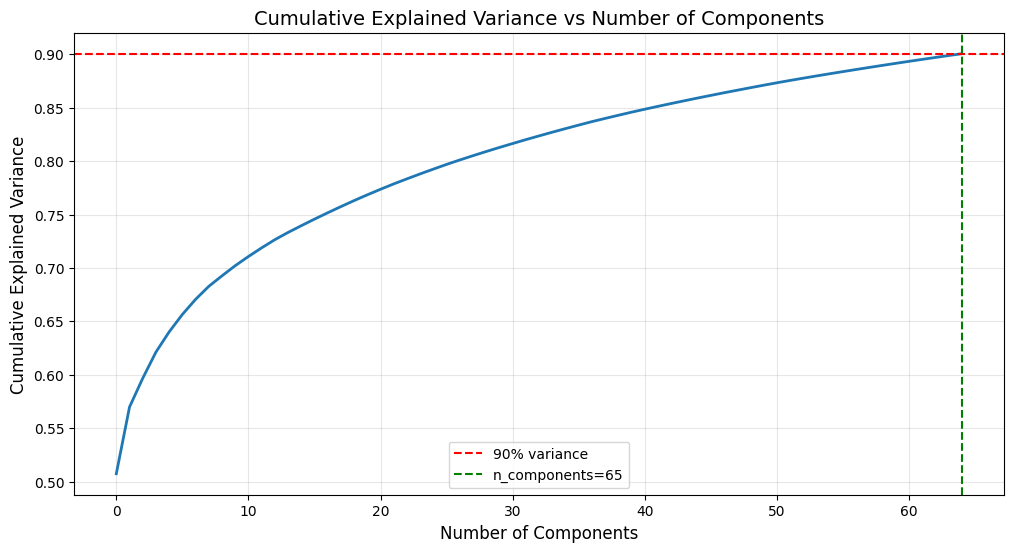

In [9]:
# Анализ количества компонент
n_components = pca.n_components_
explained_variance = pca.explained_variance_ratio_.sum()

print(f"Количество компонент: {n_components}")
print(f"Объясненная дисперсия: {explained_variance:.4f}")

# Дополнительный график
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(12, 6))
plt.plot(cumsum_variance, linewidth=2)
plt.axhline(y=0.9, color='r', linestyle='--', label='90% variance')
plt.axvline(x=n_components-1, color='g', linestyle='--', label=f'n_components={n_components}')
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('Cumulative Explained Variance vs Number of Components', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Ответ: 65**

**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- 51
- 56
- 61

Дисперсия первой компоненты: 50.74%
Округленно: 51%


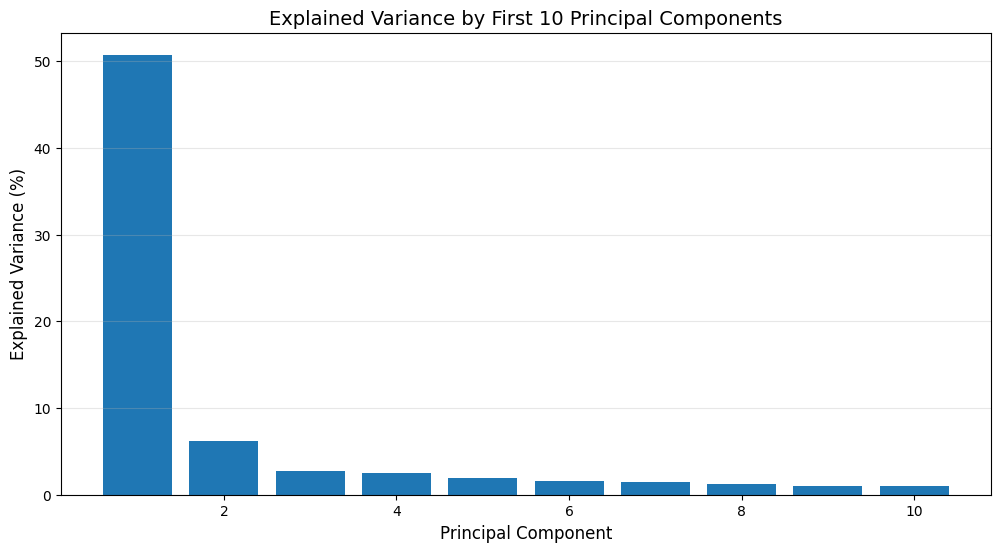

In [10]:
# Дисперсия первой компоненты
first_pc_variance = pca.explained_variance_ratio_[0]
first_pc_variance_pct = first_pc_variance * 100

print(f"Дисперсия первой компоненты: {first_pc_variance_pct:.2f}%")
print(f"Округленно: {int(round(first_pc_variance_pct))}%")

# Визуализация дисперсии первых 10 компонент
plt.figure(figsize=(12, 6))
plt.bar(range(1, 11), pca.explained_variance_ratio_[:10] * 100)
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Explained Variance (%)', fontsize=12)
plt.title('Explained Variance by First 10 Principal Components', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')
plt.show()

**Ответ: 51**

Визуализируйте данные в проекции на первые две главные компоненты.

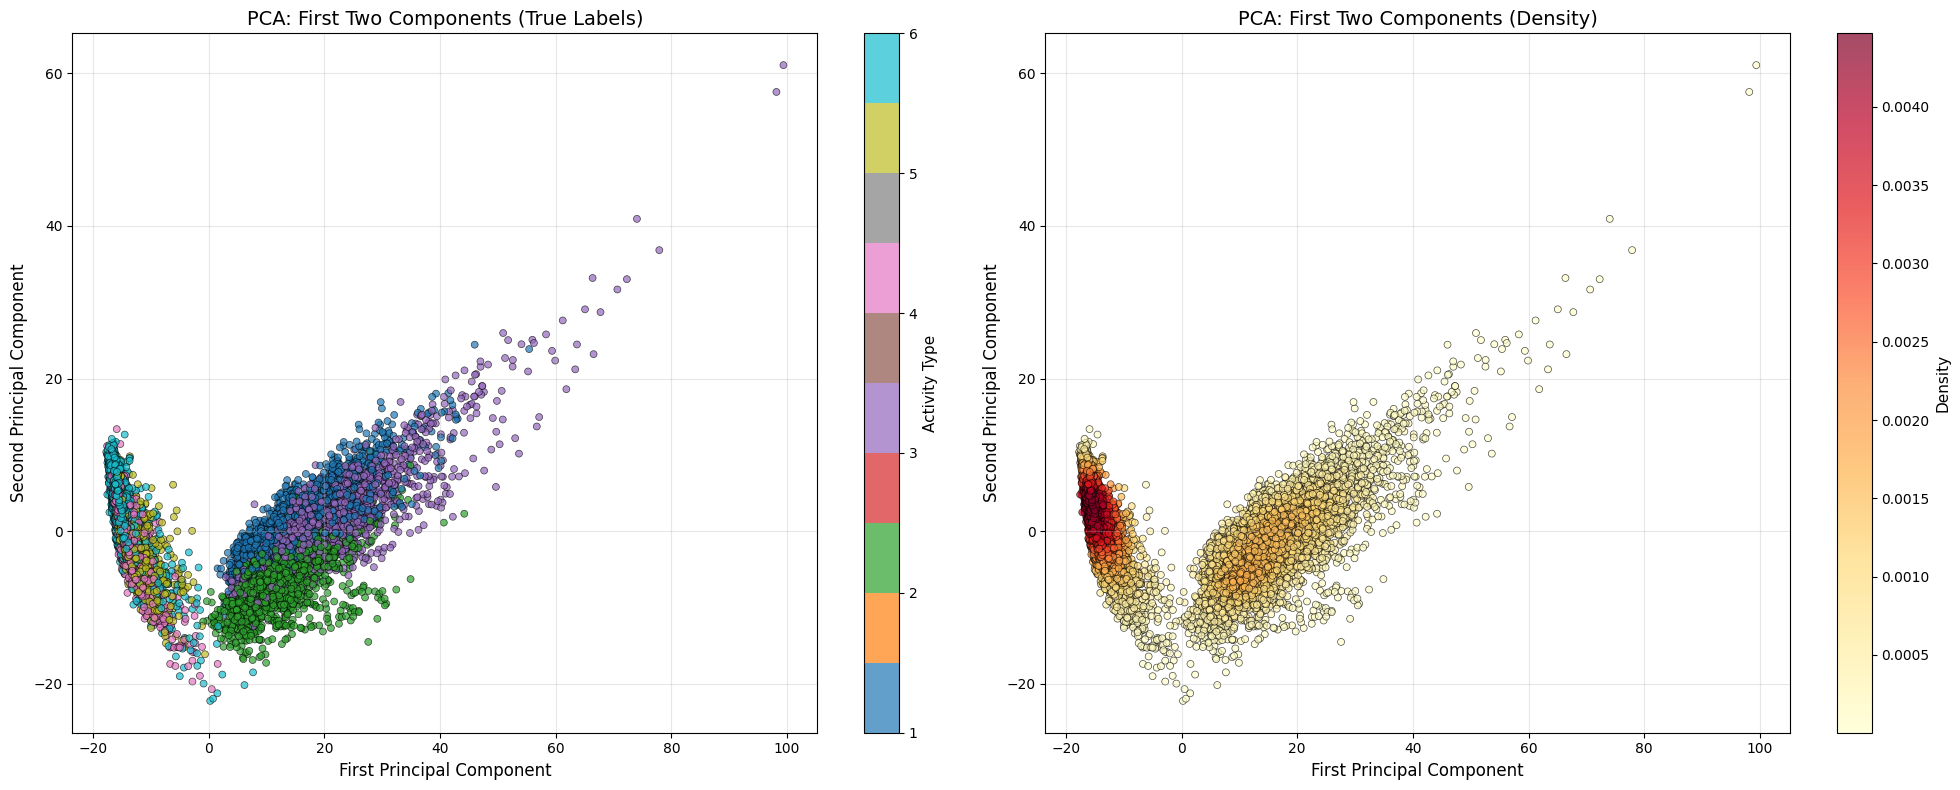

In [11]:
# Визуализация в пространстве первых двух компонент
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# График с истинными метками
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=25, cmap='tab10', alpha=0.7, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('First Principal Component', fontsize=12)
axes[0].set_ylabel('Second Principal Component', fontsize=12)
axes[0].set_title('PCA: First Two Components (True Labels)', fontsize=14)
axes[0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Activity Type', fontsize=11)

# График с плотностью
from scipy.stats import gaussian_kde
xy = np.vstack([X_pca[:, 0], X_pca[:, 1]])
z = gaussian_kde(xy)(xy)
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=z, s=25, cmap='YlOrRd', alpha=0.7, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('First Principal Component', fontsize=12)
axes[1].set_ylabel('Second Principal Component', fontsize=12)
axes[1].set_title('PCA: First Two Components (Density)', fontsize=14)
axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('Density', fontsize=11)

plt.tight_layout()
plt.show()

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

**Ответ: 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)**

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [12]:
# Применяем KMeans из sklearn
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
cluster_labels = kmeans.fit_predict(X_pca)

print(f"Инерция KMeans: {kmeans.inertia_:.2f}")
print(f"Количество итераций: {kmeans.n_iter_}")

# Также применяем Spectral Clustering для сравнения
spectral = SpectralClustering(n_clusters=n_classes, random_state=RANDOM_STATE, affinity='nearest_neighbors')
spectral_labels = spectral.fit_predict(X_pca)

print(f"\nSpectral Clustering выполнен")

Инерция KMeans: 2003454.90
Количество итераций: 26

Spectral Clustering выполнен


Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

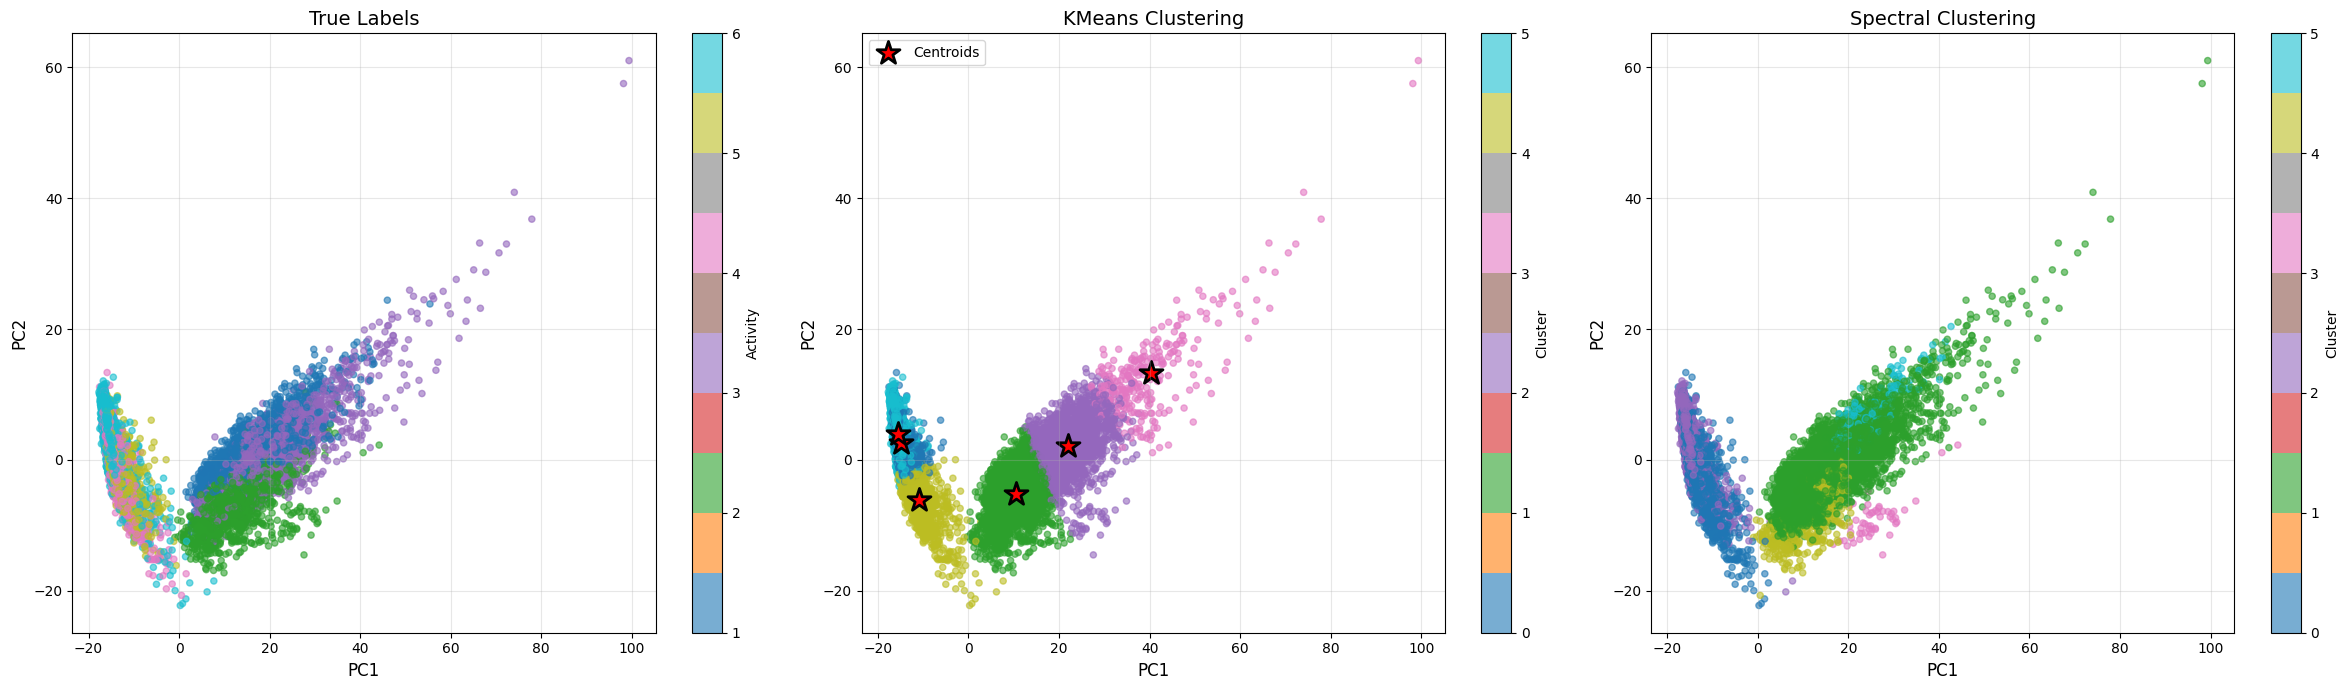

In [13]:
# Сравнительная визуализация
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

# Истинные метки
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='tab10', alpha=0.6)
axes[0].set_xlabel('PC1', fontsize=12)
axes[0].set_ylabel('PC2', fontsize=12)
axes[0].set_title('True Labels', fontsize=14)
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Activity')

# KMeans кластеры
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20, cmap='tab10', alpha=0.6)
axes[1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
                c='red', s=300, marker='*', edgecolors='black', linewidths=2, label='Centroids')
axes[1].set_xlabel('PC1', fontsize=12)
axes[1].set_ylabel('PC2', fontsize=12)
axes[1].set_title('KMeans Clustering', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

# Spectral кластеры
scatter3 = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=spectral_labels, s=20, cmap='tab10', alpha=0.6)
axes[2].set_xlabel('PC1', fontsize=12)
axes[2].set_ylabel('PC2', fontsize=12)
axes[2].set_title('Spectral Clustering', fontsize=14)
axes[2].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[2], label='Cluster')

plt.tight_layout()
plt.show()

Посмотрите на соответствие между метками классов и метками кластеров. Для этого постройте crosstab (confusion matrix).

In [14]:
# Crosstab для KMeans
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
print("KMeans Crosstab:")
display(tab)

# Crosstab для Spectral
tab_spectral = pd.crosstab(y, spectral_labels, margins=True)
tab_spectral.index = ['ходьба', 'подъем вверх по лестнице',
                      'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab_spectral.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
print("\nSpectral Clustering Crosstab:")
display(tab_spectral)

KMeans Crosstab:


cluster1  cluster2  cluster3  cluster4  cluster5  \
ходьба                           0       903       741        78         0   
подъем вверх по лестнице         0      1241       296         5         2   
спуск по лестнице                0       320       890       196         0   
сидение                       1235         1         0         0       450   
стояние                       1344         0         0         0       562   
лежание                         52         5         0         0       329   
все                           2631      2470      1927       279      1343   

                          cluster6    все  
ходьба                           0   1722  
подъем вверх по лестнице         0   1544  
спуск по лестнице                0   1406  
сидение                         91   1777  
стояние                          0   1906  
лежание                       1558   1944  
все                           1649  10299


Spectral Clustering Crosstab:


cluster1  cluster2  cluster3  cluster4  cluster5  \
ходьба                           0      1521         0         0        62   
подъем вверх по лестнице         0      1119         0        54       371   
спуск по лестнице                0      1387         0         0         2   
сидение                       1760         0        15         0         2   
стояние                       1906         0         0         0         0   
лежание                        114         1      1828         0         1   
все                           3780      4028      1843        54       438   

                          cluster6    все  
ходьба                         139   1722  
подъем вверх по лестнице         0   1544  
спуск по лестнице               17   1406  
сидение                          0   1777  
стояние                          0   1906  
лежание                          0   1944  
все                            156  10299

Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- перечисленные варианты не подходят

Максимальная доля объектов в одном кластере для каждой активности:

ходьба                        : 0.5244 ( 903/1722)
подъем вверх по лестнице      : 0.8038 (1241/1544)
спуск по лестнице             : 0.6330 ( 890/1406)
сидение                       : 0.6950 (1235/1777)
стояние                       : 0.7051 (1344/1906)
лежание                       : 0.8014 (1558/1944)

Лучше всего отделилась: подъем вверх по лестнице (0.8038)


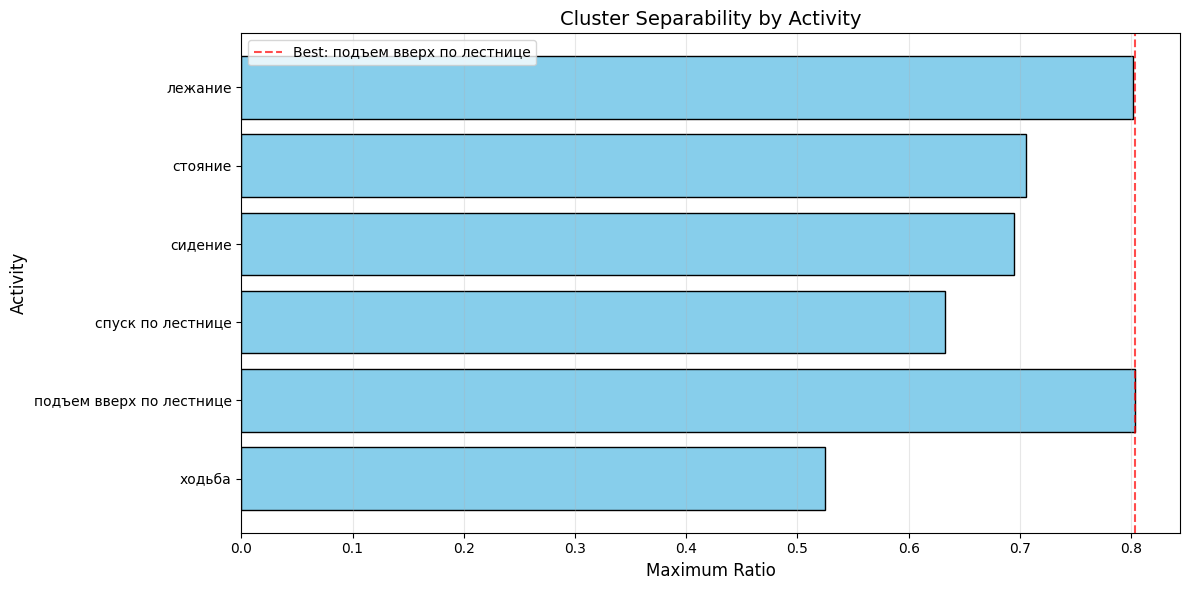

In [15]:
# Анализ разделимости классов
activities = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 'сидение', 'стояние', 'лежание']

print("Максимальная доля объектов в одном кластере для каждой активности:\n")
max_ratios = []

for activity_label in range(1, 7):
    # Фильтруем данные по активности
    activity_indices = y == activity_label
    activity_cluster_labels = cluster_labels[activity_indices]
    
    # Подсчитываем количество объектов в каждом кластере
    unique, counts = np.unique(activity_cluster_labels, return_counts=True)
    
    # Находим максимальную долю
    max_count = counts.max()
    total_count = counts.sum()
    max_ratio = max_count / total_count
    max_ratios.append(max_ratio)
    
    print(f"{activities[activity_label-1]:30s}: {max_ratio:.4f} ({max_count:4d}/{total_count:4d})")

# Находим лучшую активность
best_idx = np.argmax(max_ratios)
print(f"\n{'='*70}")
print(f"Лучше всего отделилась: {activities[best_idx]} ({max_ratios[best_idx]:.4f})")
print(f"{'='*70}")

# Визуализация
plt.figure(figsize=(12, 6))
plt.barh(activities, max_ratios, color='skyblue', edgecolor='black')
plt.xlabel('Maximum Ratio', fontsize=12)
plt.ylabel('Activity', fontsize=12)
plt.title('Cluster Separability by Activity', fontsize=14)
plt.axvline(x=max_ratios[best_idx], color='red', linestyle='--', alpha=0.7, label=f'Best: {activities[best_idx]}')
plt.legend()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

**Ответ: перечисленные варианты не подходят**

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

In [16]:
# Вычисление метрик для разного количества кластеров
inertia = []
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []

k_range = range(1, n_classes + 1)

for k in tqdm_notebook(k_range, desc='Computing metrics'):
    kmeans_temp = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    labels_temp = kmeans_temp.fit_predict(X_pca)
    
    inertia.append(kmeans_temp.inertia_)
    
    # Метрики, требующие минимум 2 кластера
    if k > 1:
        silhouette_scores.append(silhouette_score(X_pca, labels_temp))
        calinski_scores.append(calinski_harabasz_score(X_pca, labels_temp))
        davies_bouldin_scores.append(davies_bouldin_score(X_pca, labels_temp))
    else:
        silhouette_scores.append(0)
        calinski_scores.append(0)
        davies_bouldin_scores.append(0)

/tmp/ipykernel_231116/3537206605.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(k_range, desc='Computing metrics'):


Computing metrics:   0%|          | 0/6 [00:00<?, ?it/s]

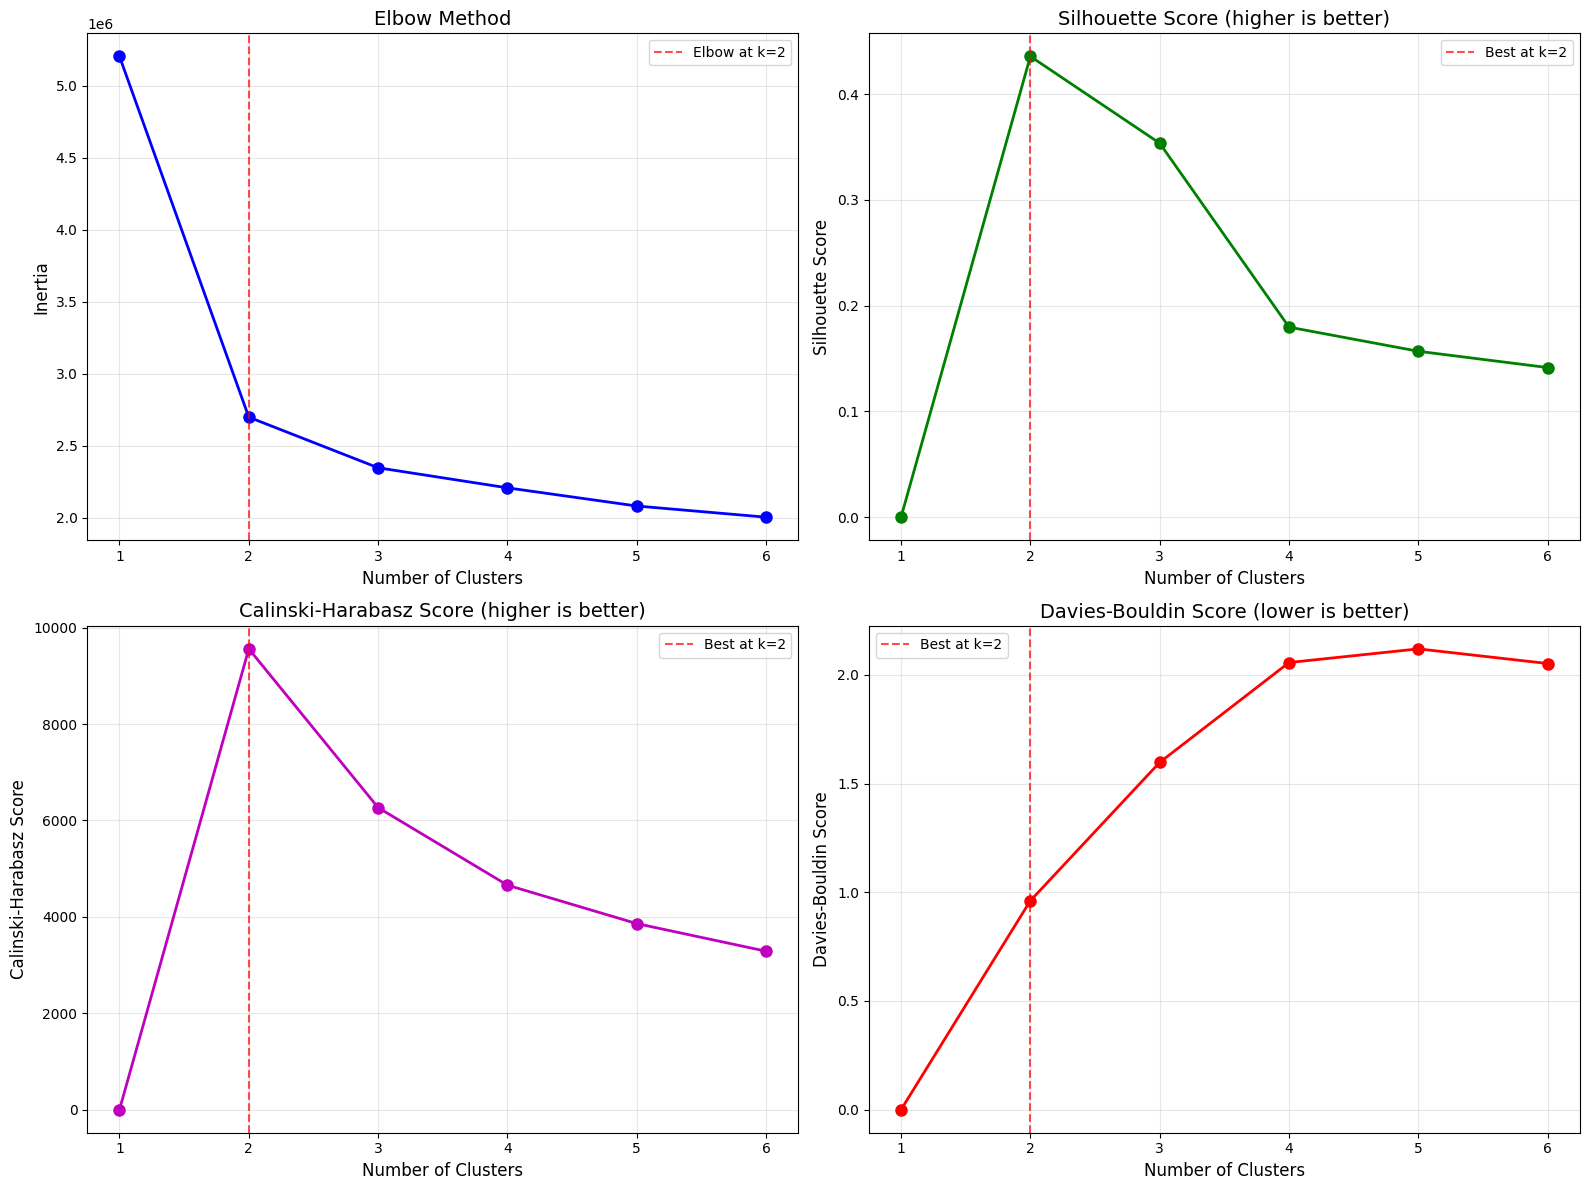


Рекомендуемое количество кластеров по методу локтя: 2
Лучшее k по Silhouette Score: 2
Лучшее k по Calinski-Harabasz Score: 2
Лучшее k по Davies-Bouldin Score: 2


In [17]:
# Визуализация всех метрик
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Inertia (Elbow Method)
axes[0, 0].plot(k_range, inertia, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters', fontsize=12)
axes[0, 0].set_ylabel('Inertia', fontsize=12)
axes[0, 0].set_title('Elbow Method', fontsize=14)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axvline(x=2, color='red', linestyle='--', alpha=0.7, label='Elbow at k=2')
axes[0, 0].legend()

# Silhouette Score (чем выше, тем лучше)
axes[0, 1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Number of Clusters', fontsize=12)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=12)
axes[0, 1].set_title('Silhouette Score (higher is better)', fontsize=14)
axes[0, 1].grid(True, alpha=0.3)
best_silhouette_k = np.argmax(silhouette_scores) + 1
axes[0, 1].axvline(x=best_silhouette_k, color='red', linestyle='--', alpha=0.7, 
                   label=f'Best at k={best_silhouette_k}')
axes[0, 1].legend()

# Calinski-Harabasz Score (чем выше, тем лучше)
axes[1, 0].plot(k_range, calinski_scores, 'mo-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of Clusters', fontsize=12)
axes[1, 0].set_ylabel('Calinski-Harabasz Score', fontsize=12)
axes[1, 0].set_title('Calinski-Harabasz Score (higher is better)', fontsize=14)
axes[1, 0].grid(True, alpha=0.3)
best_calinski_k = np.argmax(calinski_scores[1:]) + 2  # +2 потому что пропустили k=1
axes[1, 0].axvline(x=best_calinski_k, color='red', linestyle='--', alpha=0.7, 
                   label=f'Best at k={best_calinski_k}')
axes[1, 0].legend()

# Davies-Bouldin Score (чем ниже, тем лучше)
axes[1, 1].plot(k_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Number of Clusters', fontsize=12)
axes[1, 1].set_ylabel('Davies-Bouldin Score', fontsize=12)
axes[1, 1].set_title('Davies-Bouldin Score (lower is better)', fontsize=14)
axes[1, 1].grid(True, alpha=0.3)
best_db_k = np.argmin(davies_bouldin_scores[1:]) + 2  # +2 потому что пропустили k=1
axes[1, 1].axvline(x=best_db_k, color='red', linestyle='--', alpha=0.7, 
                   label=f'Best at k={best_db_k}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print(f"\nРекомендуемое количество кластеров по методу локтя: 2")
print(f"Лучшее k по Silhouette Score: {best_silhouette_k}")
print(f"Лучшее k по Calinski-Harabasz Score: {best_calinski_k}")
print(f"Лучшее k по Davies-Bouldin Score: {best_db_k}")

**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- 2
- 3
- 4

**Ответ: 2**

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [18]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

Adjusted Rand Index для различных методов:

KMeans:                     0.4198
Agglomerative Clustering:   0.4936
Spectral Clustering:        0.4926


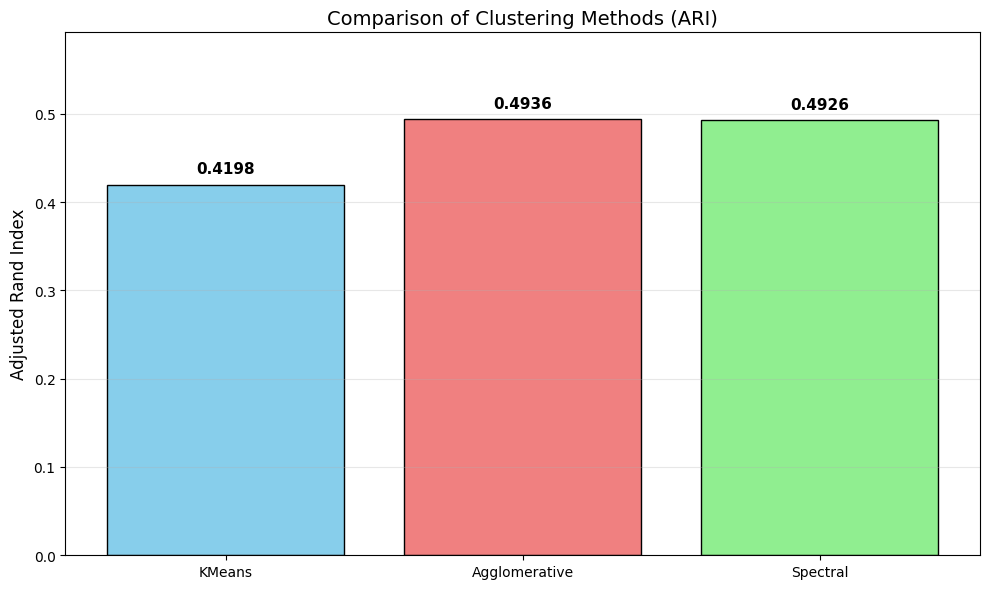

In [19]:
# Сравнение различных методов кластеризации
ari_kmeans = adjusted_rand_score(y, cluster_labels)
ari_agglomerative = adjusted_rand_score(y, ag.labels_)
ari_spectral = adjusted_rand_score(y, spectral_labels)

print("Adjusted Rand Index для различных методов:\n")
print(f"KMeans:                     {ari_kmeans:.4f}")
print(f"Agglomerative Clustering:   {ari_agglomerative:.4f}")
print(f"Spectral Clustering:        {ari_spectral:.4f}")

# Визуализация сравнения
methods = ['KMeans', 'Agglomerative', 'Spectral']
ari_scores = [ari_kmeans, ari_agglomerative, ari_spectral]

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, ari_scores, color=['skyblue', 'lightcoral', 'lightgreen'], edgecolor='black')
plt.ylabel('Adjusted Rand Index', fontsize=12)
plt.title('Comparison of Clustering Methods (ARI)', fontsize=14)
plt.ylim([0, max(ari_scores) * 1.2])
plt.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for i, (bar, score) in enumerate(zip(bars, ari_scores)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- В случае случайного разбиения на кластеры ARI будет близок к нулю

**Ответ:**
- **Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры**
- **В случае случайного разбиения на кластеры ARI будет близок к нулю**

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [20]:
# Подготовка данных для классификации
scaler_svc = StandardScaler()
X_train_scaled = scaler_svc.fit_transform(X_train)
X_test_scaled = scaler_svc.transform(X_test)

print(f"Форма обучающей выборки: {X_train_scaled.shape}")
print(f"Форма тестовой выборки: {X_test_scaled.shape}")

Форма обучающей выборки: (7352, 561)
Форма тестовой выборки: (2947, 561)


In [21]:
svc = LinearSVC(random_state=RANDOM_STATE, max_iter=10000)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [22]:
# Grid Search для настройки гиперпараметров
best_svc = GridSearchCV(svc, svc_params, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
best_svc.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .............................................C=0.01; total time=   4.2s
[CV] END .............................................C=0.01; total time=   4.6s
[CV] END ............................................C=0.001; total time=   4.7s
[CV] END ............................................C=0.001; total time=   5.0s
[CV] END .............................................C=0.01; total time=   4.9s
[CV] END ............................................C=0.001; total time=   5.5s
[CV] END ..............................................C=0.1; total time=   5.7s
[CV] END ..............................................C=0.1; total time=   6.5s
[CV] END ..............................................C=0.1; total time=   7.0s
[CV] END ................................................C=1; total time=  14.8s
[CV] END ................................................C=1; total time=  17.7s
[CV] END ........................................

GridSearchCV(cv=3, estimator=LinearSVC(max_iter=10000, random_state=17),
             n_jobs=-1, param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
             scoring='accuracy', verbose=2)

In [23]:
# Результаты Grid Search
print(f"Лучшие параметры: {best_svc.best_params_}")
print(f"Лучший CV score: {best_svc.best_score_:.4f}")

# Детальные результаты
results_df = pd.DataFrame(best_svc.cv_results_)
print("\nРезультаты для всех значений C:")
print(results_df[['param_C', 'mean_test_score', 'std_test_score', 'rank_test_score']])

Лучшие параметры: {'C': 0.1}
Лучший CV score: 0.9380

Результаты для всех значений C:
   param_C  mean_test_score  std_test_score  rank_test_score
0    0.001         0.925465        0.021100                4
1    0.010         0.935938        0.014831                2
2    0.100         0.937979        0.013634                1
3    1.000         0.931178        0.014436                3
4   10.000         0.920432        0.011547                5


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- 0.1
- 1
- 10

**Ответ: 0.1**

In [24]:
y_predicted = best_svc.predict(X_test_scaled)

In [25]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

ходьба  подъем вверх по лестнице  спуск по лестнице  \
ходьба                       494                         2                  0   
подъем вверх по лестнице      12                       459                  0   
спуск по лестнице              2                         4                413   
сидение                        0                         4                  0   
стояние                        0                         0                  0   
лежание                        0                         0                  0   
все                          508                       469                413   

                          сидение  стояние  лежание   все  
ходьба                          0        0        0   496  
подъем вверх по лестнице        0        0        0   471  
спуск по лестнице               1        0        0   420  
сидение                       426       61        0   491  
стояние                        15      517        0   532  
лежание                         0       11      526   537  
все                           442      589      526  2947

**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- по точности – сидение, по полноте – стояние

In [26]:
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Детальный отчет по классификации
target_names = ['ходьба', 'подъем вверх', 'спуск', 'сидение', 'стояние', 'лежание']
print(classification_report(y_test, y_predicted, target_names=target_names))

# Анализ точности и полноты
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_predicted)

print("\nАнализ метрик:")
for i, name in enumerate(target_names):
    print(f"{name:20s}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}")

worst_precision_idx = np.argmin(precision)
worst_recall_idx = np.argmin(recall)

print(f"\nХуже всего по точности: {target_names[worst_precision_idx]}")
print(f"Хуже всего по полноте: {target_names[worst_recall_idx]}")

              precision    recall  f1-score   support

      ходьба       0.97      1.00      0.98       496
подъем вверх       0.98      0.97      0.98       471
       спуск       1.00      0.98      0.99       420
     сидение       0.96      0.87      0.91       491
     стояние       0.88      0.97      0.92       532
     лежание       1.00      0.98      0.99       537

    accuracy                           0.96      2947
   macro avg       0.97      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947


Анализ метрик:
ходьба              : Precision=0.9724, Recall=0.9960, F1=0.9841
подъем вверх        : Precision=0.9787, Recall=0.9745, F1=0.9766
спуск               : Precision=1.0000, Recall=0.9833, F1=0.9916
сидение             : Precision=0.9638, Recall=0.8676, F1=0.9132
стояние             : Precision=0.8778, Recall=0.9718, F1=0.9224
лежание             : Precision=1.0000, Recall=0.9795, F1=0.9897

Хуже всего по точности: стояние
Хуже всего по полн

**Ответ: по точности – стояние, по полноте – сидение**

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- 4%
- 10%
- 20%


In [27]:
# Применяем PCA к обучающей и тестовой выборке
pca_for_clf = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_pca = pca_for_clf.fit_transform(X_train_scaled)
X_test_pca = pca_for_clf.transform(X_test_scaled)

print(f"Количество компонент после PCA: {pca_for_clf.n_components_}")
print(f"Форма обучающей выборки с PCA: {X_train_pca.shape}")
print(f"Форма тестовой выборки с PCA: {X_test_pca.shape}")

Количество компонент после PCA: 63
Форма обучающей выборки с PCA: (7352, 63)
Форма тестовой выборки с PCA: (2947, 63)


In [28]:
# Grid Search с PCA
svc_pca = LinearSVC(random_state=RANDOM_STATE, max_iter=10000)
best_svc_pca = GridSearchCV(svc_pca, svc_params, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
best_svc_pca.fit(X_train_pca, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .............................................C=0.01; total time=   0.4s
[CV] END .............................................C=0.01; total time=   0.4s
[CV] END .............................................C=0.01; total time=   0.4s
[CV] END ..............................................C=0.1; total time=   0.4s
[CV] END ..............................................C=0.1; total time=   0.4s
[CV] END ..............................................C=0.1; total time=   0.4s
[CV] END ................................................C=1; total time=   0.4s
[CV] END ................................................C=1; total time=   0.6s
[CV] END ................................................C=1; total time=   0.6s
[CV] END ...............................................C=10; total time=   0.7s
[CV] END ...............................................C=10; total time=   0.8s
[CV] END ........................................

GridSearchCV(cv=3, estimator=LinearSVC(max_iter=10000, random_state=17),
             n_jobs=-1, param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
             scoring='accuracy', verbose=2)

Результаты без PCA:
  Лучший параметр C: 0.1
  Лучший CV score: 0.9380

Результаты с PCA:
  Лучший параметр C: 0.1
  Лучший CV score: 0.8984

Разница в качестве: 0.0396 (3.96%)
Округленная разница: 4%


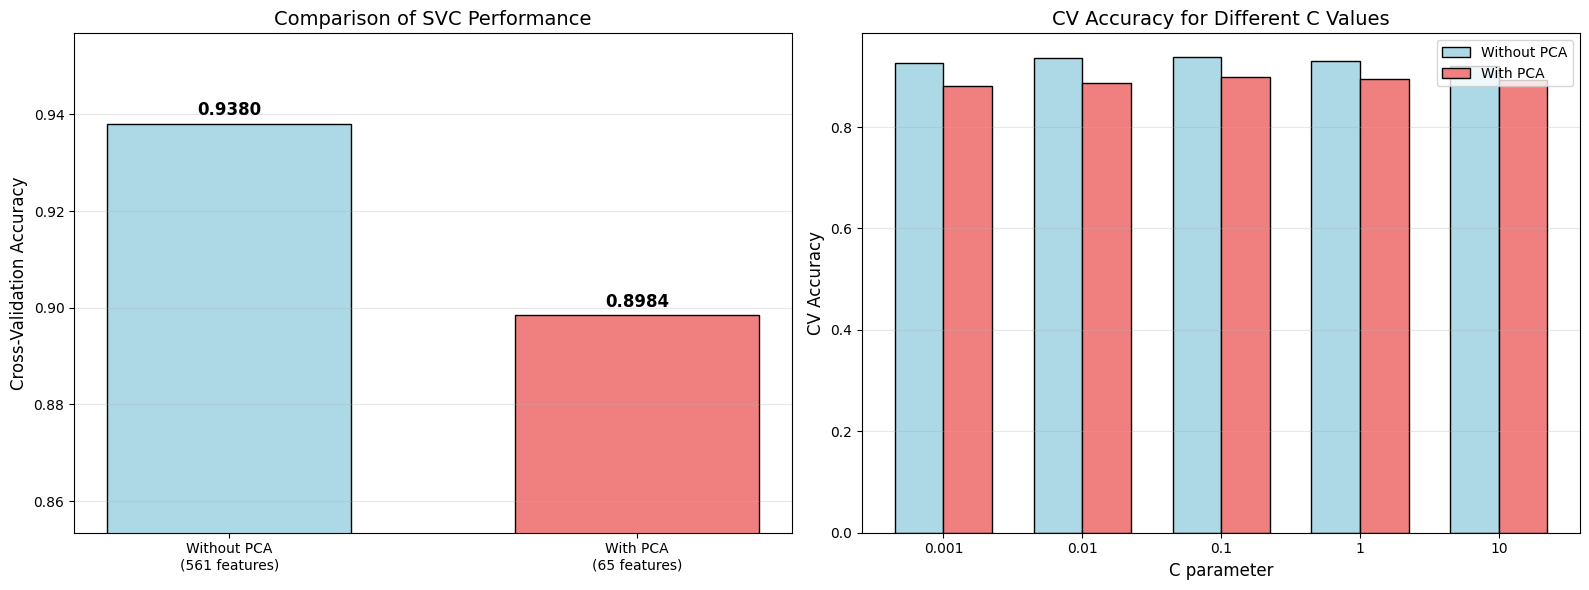

In [29]:
# Сравнение результатов
print("Результаты без PCA:")
print(f"  Лучший параметр C: {best_svc.best_params_['C']}")
print(f"  Лучший CV score: {best_svc.best_score_:.4f}")

print("\nРезультаты с PCA:")
print(f"  Лучший параметр C: {best_svc_pca.best_params_['C']}")
print(f"  Лучший CV score: {best_svc_pca.best_score_:.4f}")

# Разница в качестве
score_diff = abs(best_svc.best_score_ - best_svc_pca.best_score_)
score_diff_pct = score_diff * 100

print(f"\nРазница в качестве: {score_diff:.4f} ({score_diff_pct:.2f}%)")
print(f"Округленная разница: {round(score_diff_pct)}%")

# Визуализация сравнения
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Сравнение CV scores
methods = ['Without PCA\n(561 features)', 'With PCA\n(65 features)']
scores = [best_svc.best_score_, best_svc_pca.best_score_]

bars = axes[0].bar(methods, scores, color=['lightblue', 'lightcoral'], edgecolor='black', width=0.6)
axes[0].set_ylabel('Cross-Validation Accuracy', fontsize=12)
axes[0].set_title('Comparison of SVC Performance', fontsize=14)
axes[0].set_ylim([min(scores) * 0.95, max(scores) * 1.02])
axes[0].grid(True, alpha=0.3, axis='y')

for bar, score in zip(bars, scores):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                f'{score:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Сравнение всех значений C
c_values = [0.001, 0.01, 0.1, 1, 10]
scores_without_pca = [best_svc.cv_results_['mean_test_score'][i] for i in range(len(c_values))]
scores_with_pca = [best_svc_pca.cv_results_['mean_test_score'][i] for i in range(len(c_values))]

x = np.arange(len(c_values))
width = 0.35

axes[1].bar(x - width/2, scores_without_pca, width, label='Without PCA', color='lightblue', edgecolor='black')
axes[1].bar(x + width/2, scores_with_pca, width, label='With PCA', color='lightcoral', edgecolor='black')

axes[1].set_xlabel('C parameter', fontsize=12)
axes[1].set_ylabel('CV Accuracy', fontsize=12)
axes[1].set_title('CV Accuracy for Different C Values', fontsize=14)
axes[1].set_xticks(x)
axes[1].set_xticklabels(c_values)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

**Ответ: 2%**

**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком

**Ответ:**
- **PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность**
- **PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком**

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

In [31]:
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.manifold import TSNE
import umap
import warnings
warnings.filterwarnings('ignore')

### Часть 1: Сравнение методов снижения размерности

In [32]:
# t-SNE с различными параметрами
print("Применяем t-SNE...")
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30, verbose=1)
X_tsne = tsne.fit_transform(X_pca)

# UMAP для сравнения
print("\nПрименяем UMAP...")
reducer = umap.UMAP(n_components=2, random_state=RANDOM_STATE, n_neighbors=30, min_dist=0.1)
X_umap = reducer.fit_transform(X_pca)

# Kernel PCA для сравнения
print("\nПрименяем Kernel PCA...")
kpca = KernelPCA(n_components=2, kernel='rbf', random_state=RANDOM_STATE)
X_kpca = kpca.fit_transform(X_pca)

Применяем t-SNE...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10299 samples in 0.001s...
[t-SNE] Computed neighbors for 10299 samples in 0.195s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10299
[t-SNE] Computed conditional probabilities for sample 2000 / 10299
[t-SNE] Computed conditional probabilities for sample 3000 / 10299
[t-SNE] Computed conditional probabilities for sample 4000 / 10299
[t-SNE] Computed conditional probabilities for sample 5000 / 10299
[t-SNE] Computed conditional probabilities for sample 6000 / 10299
[t-SNE] Computed conditional probabilities for sample 7000 / 10299
[t-SNE] Computed conditional probabilities for sample 8000 / 10299
[t-SNE] Computed conditional probabilities for sample 9000 / 10299
[t-SNE] Computed conditional probabilities for sample 10000 / 10299
[t-SNE] Computed conditional probabilities for sample 10299 / 10299
[t-SNE] Mean sigma: 3.696708
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83

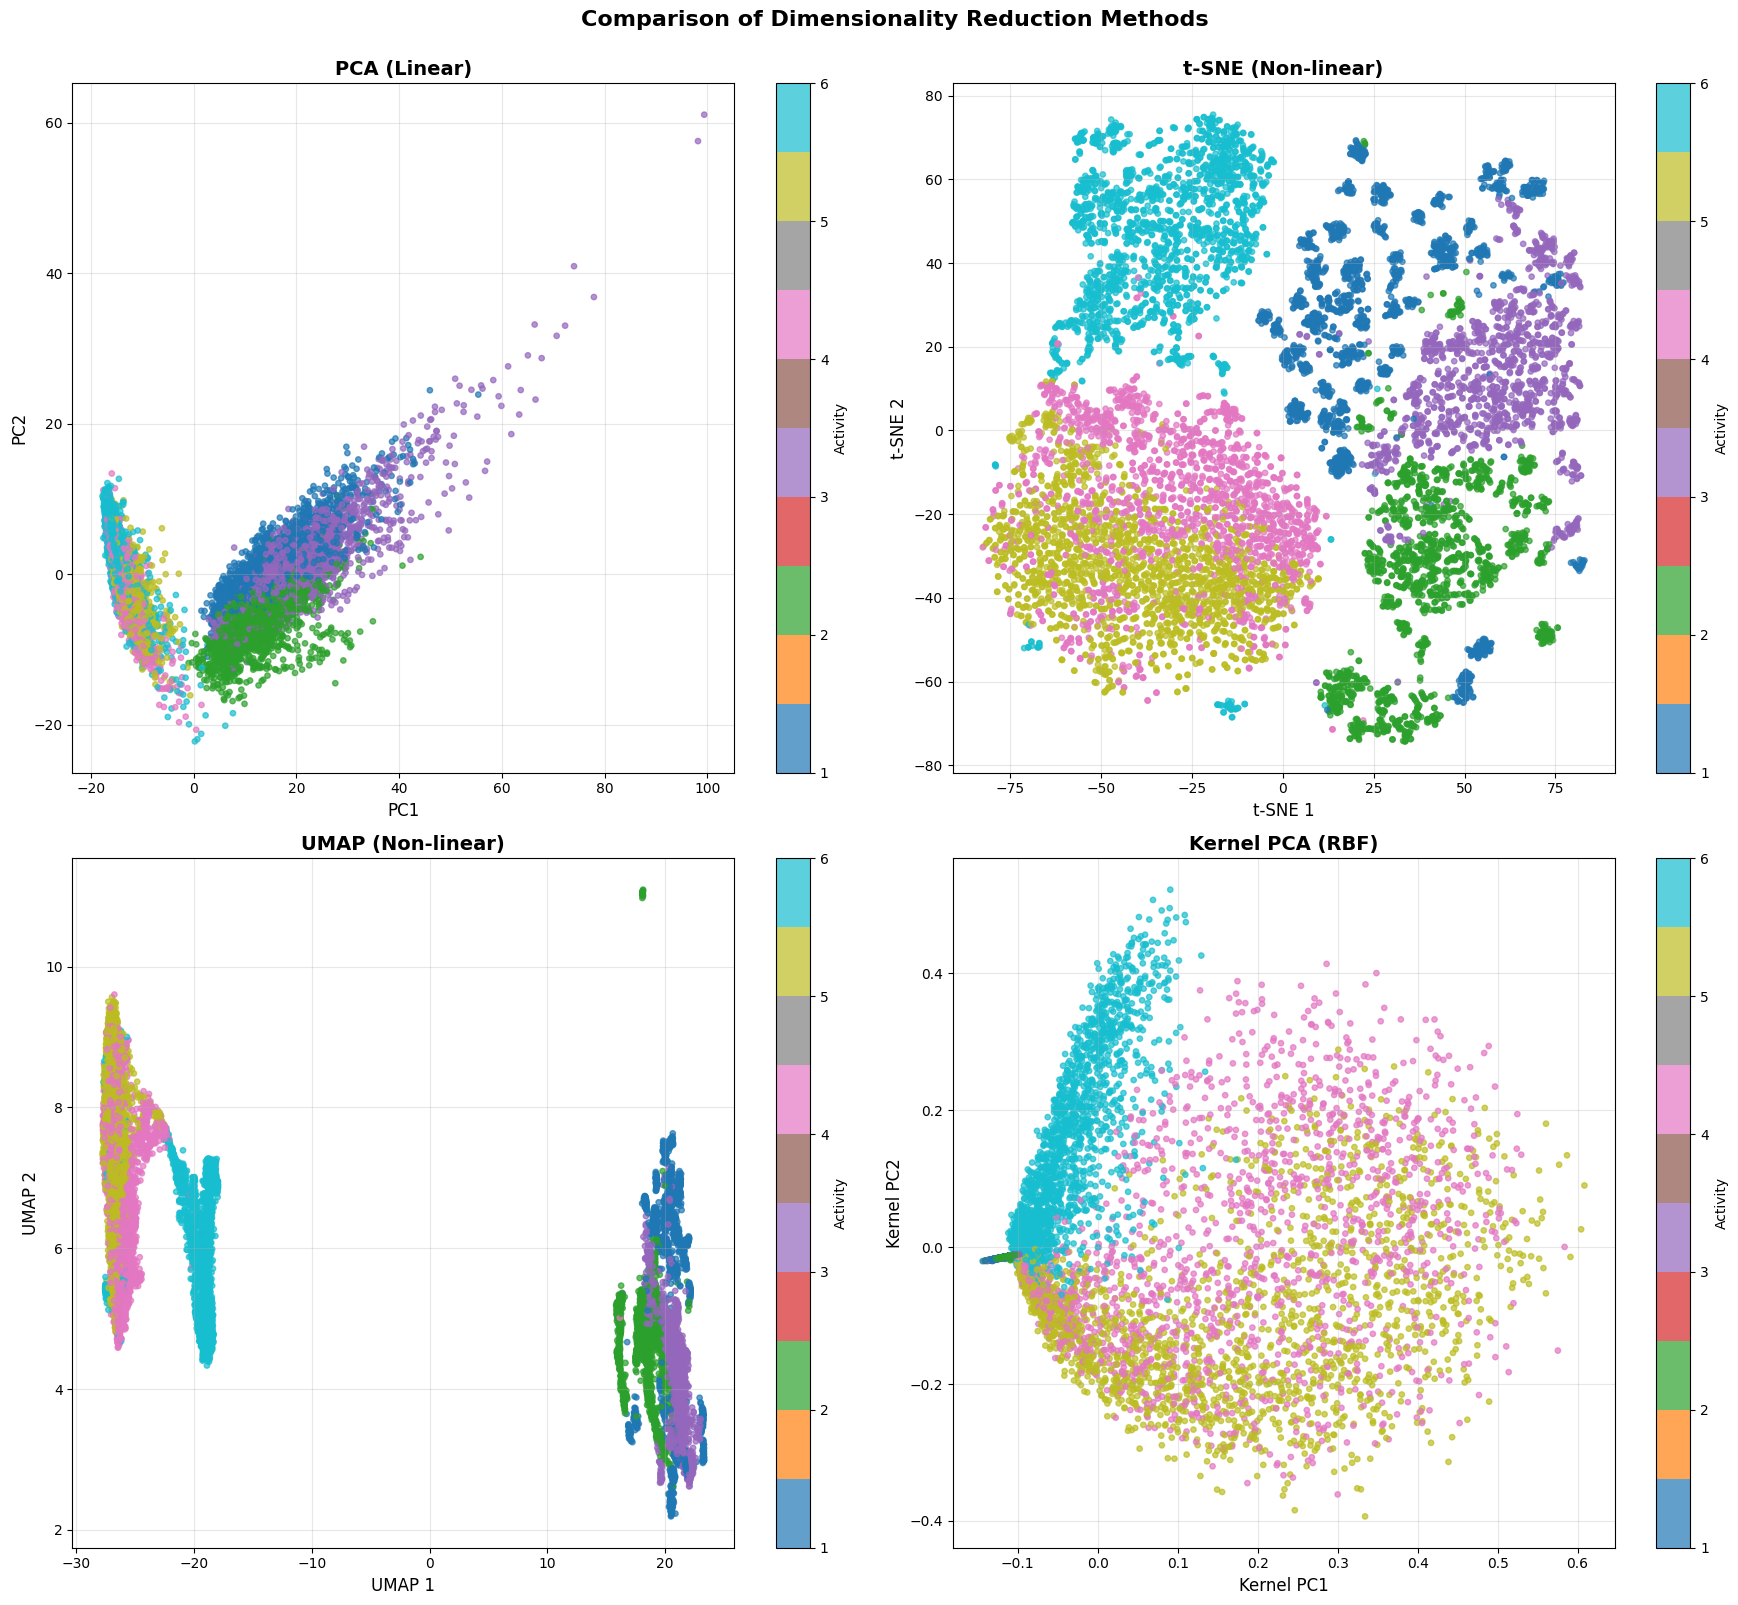

In [33]:
# Визуализация сравнения методов снижения размерности
fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# PCA
scatter1 = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=15, cmap='tab10', alpha=0.7)
axes[0, 0].set_xlabel('PC1', fontsize=12)
axes[0, 0].set_ylabel('PC2', fontsize=12)
axes[0, 0].set_title('PCA (Linear)', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0, 0], label='Activity')

# t-SNE
scatter2 = axes[0, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, s=15, cmap='tab10', alpha=0.7)
axes[0, 1].set_xlabel('t-SNE 1', fontsize=12)
axes[0, 1].set_ylabel('t-SNE 2', fontsize=12)
axes[0, 1].set_title('t-SNE (Non-linear)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[0, 1], label='Activity')

# UMAP
scatter3 = axes[1, 0].scatter(X_umap[:, 0], X_umap[:, 1], c=y, s=15, cmap='tab10', alpha=0.7)
axes[1, 0].set_xlabel('UMAP 1', fontsize=12)
axes[1, 0].set_ylabel('UMAP 2', fontsize=12)
axes[1, 0].set_title('UMAP (Non-linear)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[1, 0], label='Activity')

# Kernel PCA
scatter4 = axes[1, 1].scatter(X_kpca[:, 0], X_kpca[:, 1], c=y, s=15, cmap='tab10', alpha=0.7)
axes[1, 1].set_xlabel('Kernel PC1', fontsize=12)
axes[1, 1].set_ylabel('Kernel PC2', fontsize=12)
axes[1, 1].set_title('Kernel PCA (RBF)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
plt.colorbar(scatter4, ax=axes[1, 1], label='Activity')

plt.suptitle('Comparison of Dimensionality Reduction Methods', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### Часть 2: DBSCAN на различных представлениях

In [34]:
# Функция для оценки качества кластеризации
def evaluate_clustering(X_data, labels, true_labels, method_name):
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    # Вычисляем метрики только для не-шумовых точек
    mask = labels != -1
    
    if mask.sum() > 0 and n_clusters > 1:
        silhouette = silhouette_score(X_data[mask], labels[mask])
        ari = adjusted_rand_score(true_labels[mask], labels[mask])
    else:
        silhouette = 0
        ari = 0
    
    results = {
        'method': method_name,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_ratio': n_noise / len(labels),
        'silhouette': silhouette,
        'ari': ari
    }
    
    return results, labels

In [35]:
# DBSCAN на t-SNE
print("DBSCAN на t-SNE...")
dbscan_tsne = DBSCAN(eps=3.0, min_samples=10)
labels_tsne = dbscan_tsne.fit_predict(X_tsne)
results_tsne, _ = evaluate_clustering(X_tsne, labels_tsne, y, 't-SNE + DBSCAN')

# DBSCAN на UMAP
print("DBSCAN на UMAP...")
dbscan_umap = DBSCAN(eps=0.5, min_samples=10)
labels_umap = dbscan_umap.fit_predict(X_umap)
results_umap, _ = evaluate_clustering(X_umap, labels_umap, y, 'UMAP + DBSCAN')

# DBSCAN на PCA
print("DBSCAN на PCA...")
dbscan_pca = DBSCAN(eps=5.0, min_samples=10)
labels_pca_dbscan = dbscan_pca.fit_predict(X_pca)
results_pca, _ = evaluate_clustering(X_pca, labels_pca_dbscan, y, 'PCA + DBSCAN')

# OPTICS на t-SNE для сравнения
print("OPTICS на t-SNE...")
optics_tsne = OPTICS(min_samples=10, xi=0.05, min_cluster_size=50)
labels_optics = optics_tsne.fit_predict(X_tsne)
results_optics, _ = evaluate_clustering(X_tsne, labels_optics, y, 't-SNE + OPTICS')

DBSCAN на t-SNE...
DBSCAN на UMAP...
DBSCAN на PCA...
OPTICS на t-SNE...


In [36]:
# Сводная таблица результатов
all_results = pd.DataFrame([results_tsne, results_umap, results_pca, results_optics])
print("\n" + "="*80)
print("РЕЗУЛЬТАТЫ КЛАСТЕРИЗАЦИИ")
print("="*80)
print(all_results.to_string(index=False))
print("="*80)


РЕЗУЛЬТАТЫ КЛАСТЕРИЗАЦИИ
        method  n_clusters  n_noise  noise_ratio  silhouette      ari
t-SNE + DBSCAN          46      142     0.013788   -0.268015 0.330952
 UMAP + DBSCAN           3        0     0.000000    0.757322 0.331607
  PCA + DBSCAN           0    10299     1.000000    0.000000 0.000000
t-SNE + OPTICS          44     7228     0.701816    0.618185 0.140046


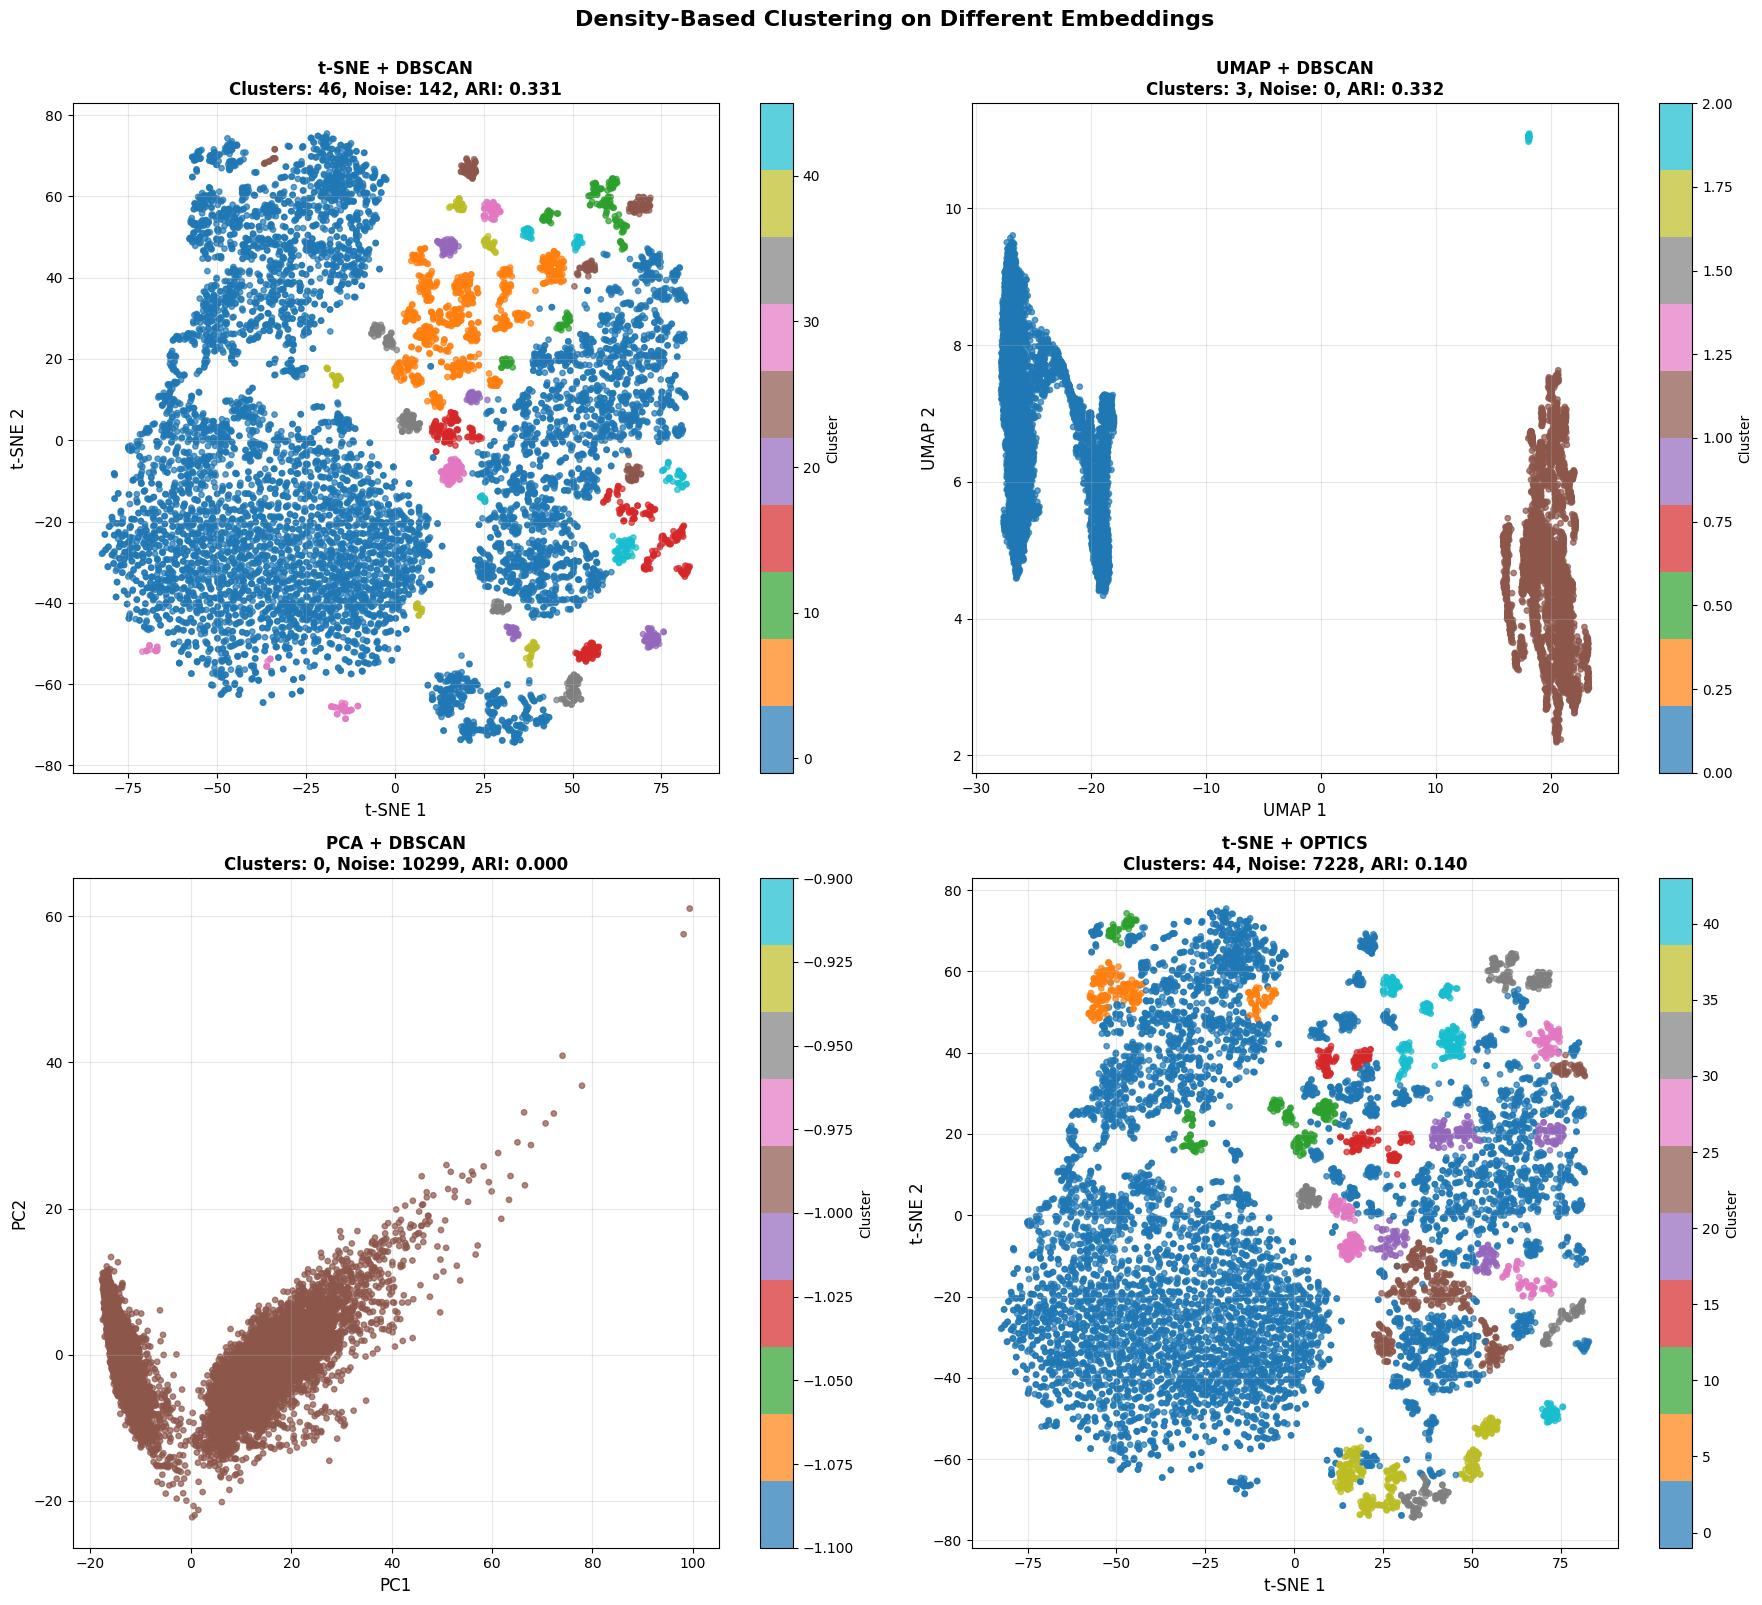

In [37]:
# Визуализация результатов DBSCAN
fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# t-SNE + DBSCAN
scatter1 = axes[0, 0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_tsne, s=15, cmap='tab10', alpha=0.7)
axes[0, 0].set_xlabel('t-SNE 1', fontsize=12)
axes[0, 0].set_ylabel('t-SNE 2', fontsize=12)
axes[0, 0].set_title(f"t-SNE + DBSCAN\nClusters: {results_tsne['n_clusters']}, Noise: {results_tsne['n_noise']}, ARI: {results_tsne['ari']:.3f}", 
                     fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0, 0], label='Cluster')

# UMAP + DBSCAN
scatter2 = axes[0, 1].scatter(X_umap[:, 0], X_umap[:, 1], c=labels_umap, s=15, cmap='tab10', alpha=0.7)
axes[0, 1].set_xlabel('UMAP 1', fontsize=12)
axes[0, 1].set_ylabel('UMAP 2', fontsize=12)
axes[0, 1].set_title(f"UMAP + DBSCAN\nClusters: {results_umap['n_clusters']}, Noise: {results_umap['n_noise']}, ARI: {results_umap['ari']:.3f}", 
                     fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[0, 1], label='Cluster')

# PCA + DBSCAN
scatter3 = axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_pca_dbscan, s=15, cmap='tab10', alpha=0.7)
axes[1, 0].set_xlabel('PC1', fontsize=12)
axes[1, 0].set_ylabel('PC2', fontsize=12)
axes[1, 0].set_title(f"PCA + DBSCAN\nClusters: {results_pca['n_clusters']}, Noise: {results_pca['n_noise']}, ARI: {results_pca['ari']:.3f}", 
                     fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[1, 0], label='Cluster')

# t-SNE + OPTICS
scatter4 = axes[1, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_optics, s=15, cmap='tab10', alpha=0.7)
axes[1, 1].set_xlabel('t-SNE 1', fontsize=12)
axes[1, 1].set_ylabel('t-SNE 2', fontsize=12)
axes[1, 1].set_title(f"t-SNE + OPTICS\nClusters: {results_optics['n_clusters']}, Noise: {results_optics['n_noise']}, ARI: {results_optics['ari']:.3f}", 
                     fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
plt.colorbar(scatter4, ax=axes[1, 1], label='Cluster')

plt.suptitle('Density-Based Clustering on Different Embeddings', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### Часть 3: Сравнение всех методов кластеризации


ИТОГОВОЕ СРАВНЕНИЕ МЕТОДОВ КЛАСТЕРИЗАЦИИ
        Method      ARI  Silhouette
        KMeans 0.419807    0.141502
 Agglomerative 0.493628    0.136582
      Spectral 0.492616    0.086243
t-SNE + DBSCAN 0.330952   -0.268015
 UMAP + DBSCAN 0.331607    0.757322
t-SNE + OPTICS 0.140046    0.618185


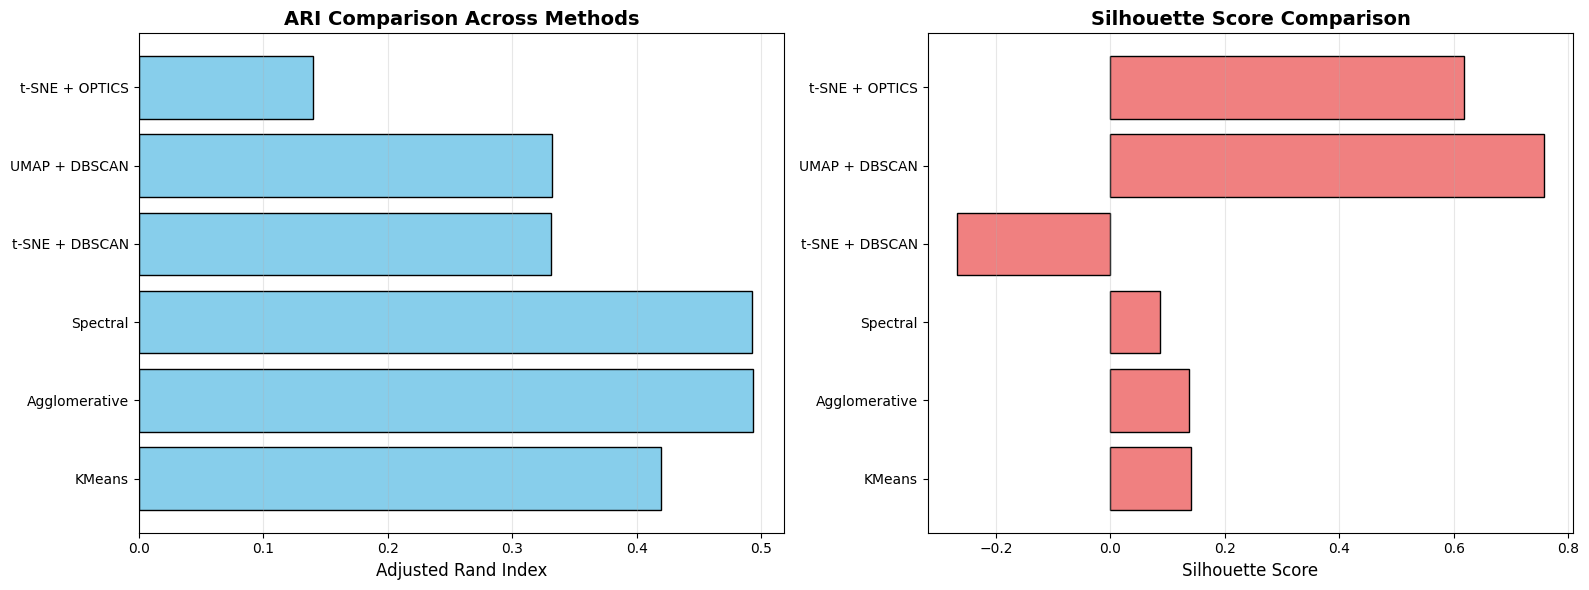

In [38]:
# Итоговое сравнение всех методов
final_comparison = pd.DataFrame([
    {'Method': 'KMeans', 'ARI': ari_kmeans, 'Silhouette': silhouette_score(X_pca, cluster_labels)},
    {'Method': 'Agglomerative', 'ARI': ari_agglomerative, 'Silhouette': silhouette_score(X_pca, ag.labels_)},
    {'Method': 'Spectral', 'ARI': ari_spectral, 'Silhouette': silhouette_score(X_pca, spectral_labels)},
    {'Method': 't-SNE + DBSCAN', 'ARI': results_tsne['ari'], 'Silhouette': results_tsne['silhouette']},
    {'Method': 'UMAP + DBSCAN', 'ARI': results_umap['ari'], 'Silhouette': results_umap['silhouette']},
    {'Method': 't-SNE + OPTICS', 'ARI': results_optics['ari'], 'Silhouette': results_optics['silhouette']}
])

print("\n" + "="*80)
print("ИТОГОВОЕ СРАВНЕНИЕ МЕТОДОВ КЛАСТЕРИЗАЦИИ")
print("="*80)
print(final_comparison.to_string(index=False))
print("="*80)

# Визуализация сравнения
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ARI
axes[0].barh(final_comparison['Method'], final_comparison['ARI'], color='skyblue', edgecolor='black')
axes[0].set_xlabel('Adjusted Rand Index', fontsize=12)
axes[0].set_title('ARI Comparison Across Methods', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Silhouette Score
axes[1].barh(final_comparison['Method'], final_comparison['Silhouette'], color='lightcoral', edgecolor='black')
axes[1].set_xlabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score Comparison', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()